## GA demystified for cosmological parameter estimation: Analysis

We obtain the results presented in [arXiv:2505.10450](https://arxiv.org/abs/2505.10450) which were obtained by `CosmoGA_fitness.ipynb`, `CosmoGA_crossover.ipynb`, and `CosmoGA_mutation.py`. Users are encouraged to explore the corresponding cases for the mutation type, crossover type, and the selection operator (type and rate).

In [1]:
%matplotlib inline
import sys
import astropy.cosmology.flrw as flrw
sys.modules['astropy.cosmology.flrw.lambdacdm'] = flrw
sys.modules['astropy.cosmology.flrw'] = flrw

import os
import numpy as np
import matplotlib.pyplot as plt
import pygad

import numdifftools as nd
from numpy.linalg import inv

from astropy.cosmology import LambdaCDM

### 0. Data and likelihood

First we setup the data and the likelihood. In the context of GA the fitness function can be considered as a function of the likelihood.

The data sets are imported below directly from their official sources;

In [2]:
folder=''

# import the data points
filename = 'https://gitlab.com/mmoresco/CCcovariance/-/raw/master/data/HzTable_MM_BC03.dat'
z_cc, Hz_cc, errHz_cc = np.genfromtxt(folder + filename, comments = '#', usecols = (0,1,2), \
                                      unpack = True, delimiter = ',')
# above error bars for plotting only; use full covariance matrix to estimate cosmo params

# import and calculate covariance matrix
# import CC covariance matrix data
filename = 'https://gitlab.com/mmoresco/CCcovariance/-/raw/master/data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(folder + filename, comments = '#', \
                                             usecols = (0,1,2,3,4), unpack = True)

# calculate CC covariance matrix
cov_mat_diag = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')

for i in range(len(z_cc)):
    cov_mat_diag[i,i] = errHz_cc[i]**2

imf_intp = np.interp(z_cc, zmod, imf)/100
slib_intp = np.interp(z_cc, zmod, slib)/100
sps_intp = np.interp(z_cc, zmod, sps)/100
spsooo_intp = np.interp(z_cc, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_slib = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_sps = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_spsooo = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')

for i in range(len(z_cc)):
    for j in range(len(z_cc)):
        cov_mat_imf[i,j] = Hz_cc[i] * imf_intp[i] * Hz_cc[j] * imf_intp[j]
        cov_mat_slib[i,j] = Hz_cc[i] * slib_intp[i] * Hz_cc[j] * slib_intp[j]
        cov_mat_sps[i,j] = Hz_cc[i] * sps_intp[i] * Hz_cc[j] * sps_intp[j]
        cov_mat_spsooo[i,j] = Hz_cc[i] * spsooo_intp[i] * Hz_cc[j] * spsooo_intp[j]

C_cc = cov_mat_spsooo + cov_mat_imf + cov_mat_diag # full CC covariance
C_cc_inv = inv(C_cc)


# import supernovae data
loc_lcparam = 'https://github.com/PantheonPlusSH0ES/DataRelease/raw/main/\
Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat'

# pantheon plus systematics
lcparam = np.loadtxt(loc_lcparam, skiprows = 1, usecols = (2, 8, 9, 10, 11))

# setup pantheon samples with z > 0.01
z_pp = lcparam[:, 0][111:]
mMz_pp = lcparam[:, 3][111:]
sigmMz_pp = lcparam[:, 4][111:]

# load the pantheon+ covariance matrix
loc_lcparam_sys = 'https://raw.githubusercontent.com/PantheonPlusSH0ES/\
DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov'

lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)

# pantheon plus systematics
C_sne = lcparam_sys.reshape(1701, 1701)
C_sne_inv = np.linalg.inv(C_sne[111:, 111:])

These are visualized below;

The diagonals of the covariance matrices are used for visualization only. For the analysis we use the full covariances.

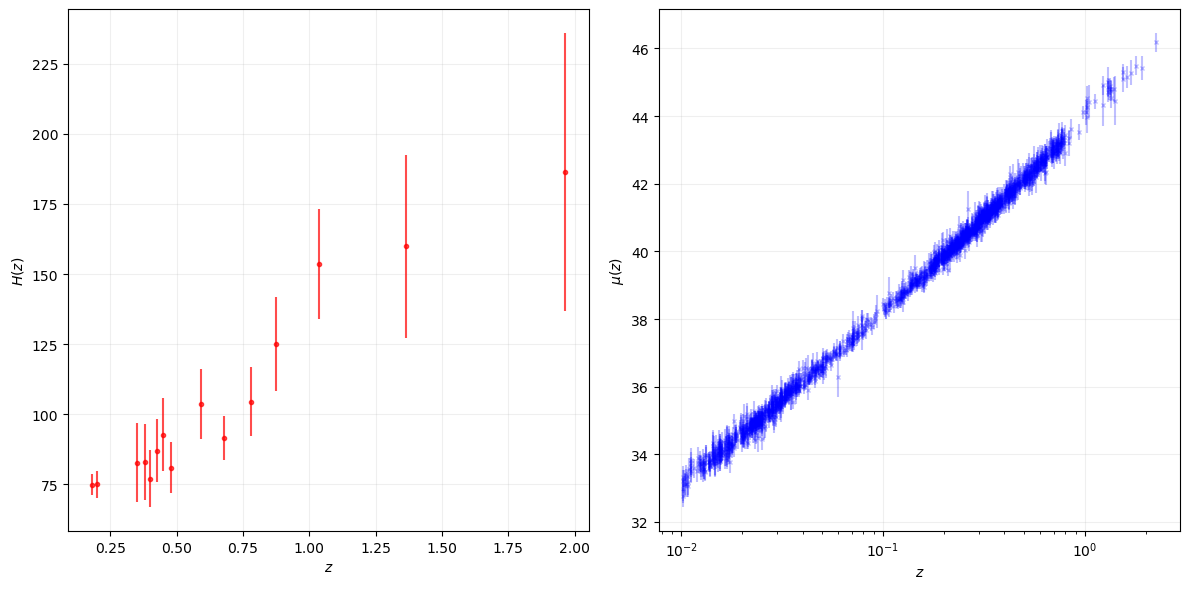

In [3]:
# plot to visualize
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))
ax[0].errorbar(z_cc, Hz_cc, yerr = errHz_cc, fmt = 'ro', markersize = 3, alpha=0.7)
ax[0].set_xlabel(r'$z$'); ax[0].set_ylabel(r'$H(z)$')
ax[0].grid(True, alpha=0.2)

ax[1].errorbar(z_pp, mMz_pp, yerr = sigmMz_pp, fmt = 'bx', markersize = 3, alpha=0.25)
ax[1].set_xscale('log')
ax[1].set_xlabel('$z$'); ax[1].set_ylabel('$\mu(z)$')
ax[1].grid(True, alpha=0.2)

fig.tight_layout()
plt.show()

In the following, we setup the likelihoods for a curved LCDM model; utilizing `astropy`. For convenience we setup a likelihood separately for the CC only case and when CC + SNe are considered;

In [4]:
# flat priors
H0_min, H0_max = 0, 100
Om0_min, Om0_max = 0, 1
Ode0_min, Ode0_max = 0, 1

def llflatprior(x):
    H0, Om0, Ode0 = x
    # if (H0_min < H0 < H0_max and Om0_min < Om0 < Om0_max \
    #     and Ok0_min < Ok0 < Ok0_max):
    if (H0_min < H0 < H0_max and Om0_min < Om0 < Om0_max \
        and Ode0_min < Ode0 < Ode0_max):
        return 0.0
    return -np.inf


# CC only likelihood
def Chi2_CC(x):
    # H0, Om0, Ok0 = x
    # cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0)
    H0, Om0, Ode0 = x
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    dev_cc = Hz_cc - cosmo.H(z_cc).value
    return dev_cc.T @ C_cc_inv @ dev_cc

def llprob_CC(x):
    H0, Om0, Ode0 = x
    if (Om0 < 0) or (H0 < 0):
        return -np.inf
    lp = llflatprior(x)
    lk = -0.5*Chi2_CC(x)
    if np.isnan(lk):
        return -np.inf
    return lp + lk if np.isfinite(lp) else -np.inf


# CC + SNe likelihood
def Chi2_SNe(x):
    # H0, Om0, Ok0 = x
    # cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0)
    H0, Om0, Ode0 = x
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    dev_sne = mMz_pp - cosmo.distmod(z_pp).value
    return dev_sne.T @ C_sne_inv @ dev_sne

def llprob_CCSNe(x):
    H0, Om0, Ode0 = x
    if (Om0 < 0) or (H0 < 0):
        return -np.inf
    lp = llflatprior(x)
    lk = -0.5*(Chi2_CC(x) + Chi2_SNe(x))
    if np.isnan(lk):
        return -np.inf
    return lp + lk if np.isfinite(lp) else -np.inf

For convenience we also prepare a function that would derive the Fisher matrix uncertainty estimate given an instance of pygad; which contains the GA population and solution;

In [5]:
# predicts covariance matrix using Fisher matrix
def get_ga_fisher(ga_instance, loglike, nsamps=10000):
    ga_sol = ga_instance.best_solution()[0]
    hess = -nd.Hessian(loglike)(ga_sol)
    inv_hess = np.linalg.inv(hess)
    ga_fisher = np.random.multivariate_normal(ga_sol, inv_hess, size=nsamps)
    return ga_fisher

We also setup a utility function to print the relevant statistics given a set of samples (e.g., that were obtained using GA or MCMC);

In [10]:
def print_stats(samples, in_latex=False, precision=1):
    # separate the samples into H0, Om0, and Ode0
    H0_samples = samples[:, 0]
    Om0_samples = samples[:, 1]
    Ode0_samples = samples[:, 2]

    # compute the mean and 16th, 50th (median), and 84th percentiles for each parameter
    H0_mean = np.mean(H0_samples)
    H0_16th, H0_50th, H0_84th = np.percentile(H0_samples, [16, 50, 84])
    
    Om0_mean = np.mean(Om0_samples)
    Om0_16th, Om0_50th, Om0_84th = np.percentile(Om0_samples, [16, 50, 84])
    
    Ode0_mean = np.mean(Ode0_samples)
    Ode0_16th, Ode0_50th, Ode0_84th = np.percentile(Ode0_samples, [16, 50, 84])

    # calculate the uncertainties as the difference between the 84th and 16th percentiles
    H0_uncertainty_upper = H0_84th - H0_50th
    H0_uncertainty_lower = H0_50th - H0_16th

    Om0_uncertainty_upper = Om0_84th - Om0_50th
    Om0_uncertainty_lower = Om0_50th - Om0_16th

    Ode0_uncertainty_upper = Ode0_84th - Ode0_50th
    Ode0_uncertainty_lower = Ode0_50th - Ode0_16th

    # create the format string for the desired precision
    fmt = f".{precision}f"

    if in_latex:
        # print the LaTeX formatted results
        print(f"H0 = ${H0_50th:{fmt}}^{{+{H0_uncertainty_upper:{fmt}}}}_{{-{H0_uncertainty_lower:{fmt}}}}$")
        print(f"Om0 = ${Om0_50th:{fmt}}^{{+{Om0_uncertainty_upper:{fmt}}}}_{{-{Om0_uncertainty_lower:{fmt}}}}$")
        print(f"Ode0 = ${Ode0_50th:{fmt}}^{{+{Ode0_uncertainty_upper:{fmt}}}}_{{-{Ode0_uncertainty_lower:{fmt}}}}$")
    else:
        # print the results
        print(f"H0 = {H0_50th:{fmt}} + {H0_uncertainty_upper:{fmt}} - {H0_uncertainty_lower:{fmt}}")
        print(f"Om0 = {Om0_50th:{fmt}} + {Om0_uncertainty_upper:{fmt}} - {Om0_uncertainty_lower:{fmt}}")
        print(f"Ode0 = {Ode0_50th:{fmt}} + {Ode0_uncertainty_upper:{fmt}} - {Ode0_uncertainty_lower:{fmt}}")

### 1. CC only

#### 1.1 Changing fitness function

Now let's see the results of varying the form of the fitness function; the chosen forms are given by:

```python
# pure CC data

def fitness_func_0(ga_instance, chromosome, chromosome_idx):
    return llprob_CC(chromosome)

def fitness_func_1(ga_instance, chromosome, chromosome_idx):
    chi2 = -2*llprob_CC(chromosome)
    return 100/chi2

def fitness_func_2(ga_instance, chromosome, chromosome_idx):
    return np.exp(llprob_CC(chromosome))
```

The crossover and adaptive mutation rates are given by
```python
# crossover = 0.5
# mutation = [0.5, 0.3]
```

The results shown in the following have been obtained using `CosmoGA_fitness.ipynb` and are stored in the directory `./data`;

In [7]:
# to load: ga_instance = pygad.load(filename=filename)
ga_instance_0 = pygad.load('data/ga_cc_fitness_0')
ga_instance_1 = pygad.load('data/ga_cc_fitness_1')
ga_instance_2 = pygad.load('data/ga_cc_fitness_2')

# this recovers the last population from the runs
ga_samps_0 = ga_instance_0.population
ga_samps_1 = ga_instance_1.population
ga_samps_2 = ga_instance_2.population

The sample statistics are now easily calculated as follows;

In [11]:
use_latex=True
print('FF_0'); print_stats(ga_samps_0, in_latex=use_latex); print()

print('FF_1'); print_stats(ga_samps_1, in_latex=use_latex); print()

print('FF_2'); print_stats(ga_samps_2, in_latex=use_latex); print()

FF_0
H0 = $20.2^{+59.0}_{-17.2}$
Om0 = $0.5^{+0.3}_{-0.3}$
Ode0 = $0.5^{+0.3}_{-0.3}$

FF_1
H0 = $64.3^{+6.8}_{-26.7}$
Om0 = $0.4^{+0.3}_{-0.2}$
Ode0 = $0.6^{+0.3}_{-0.4}$

FF_2
H0 = $67.8^{+1.6}_{-23.2}$
Om0 = $0.5^{+0.1}_{-0.1}$
Ode0 = $0.8^{+0.1}_{-0.4}$



These are the values in Table 1 of 2505.10450. The parameter distributions are shown below;

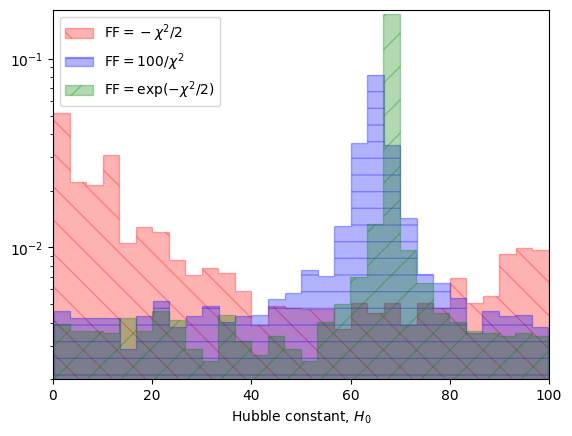

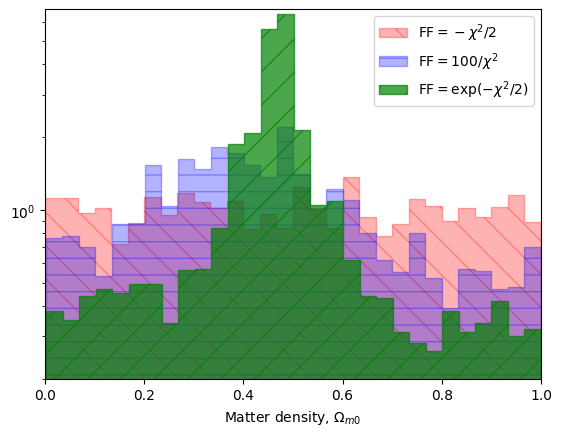

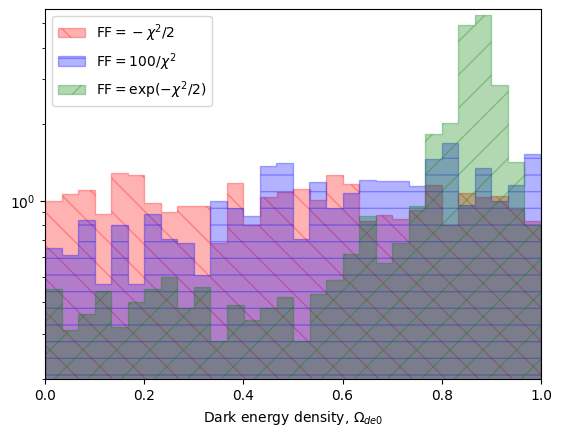

In [ ]:
fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'FF$=-\chi^2/2$', rasterized=True);
ax.hist(ga_samps_1[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'FF$=100/\chi^2$', rasterized=True);
ax.hist(ga_samps_2[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'FF$=\exp(-\chi^2/2)$', rasterized=True);
ax.set_xlabel(r'Hubble constant, $H_0$')
ax.set_xlim(0,100)
ax.set_ylim(bottom=2e-3)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/cc_fitness_H0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'FF$=-\chi^2/2$', rasterized=True);
ax.hist(ga_samps_1[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'FF$=100/\chi^2$', rasterized=True);
ax.hist(ga_samps_2[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.7, density=True, \
        label = r'FF$=\exp(-\chi^2/2)$', rasterized=True);
ax.set_xlabel(r'Matter density, $\Omega_{m0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=2e-1)
ax.set_yscale('log')
ax.legend(loc='upper right')
# fig.savefig('figs/cc_fitness_Om0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'FF$=-\chi^2/2$', rasterized=True);
ax.hist(ga_samps_1[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'FF$=100/\chi^2$', rasterized=True);
ax.hist(ga_samps_2[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'FF$=\exp(-\chi^2/2)$', rasterized=True);
ax.set_xlabel(r'Dark energy density, $\Omega_{de0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=2e-1)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/cc_fitness_Ode0.pdf')
plt.show()

These are the left panel of Figure 3.

#### 1.2 Changing mutation

Now, let's do everything at once (loading the data, printing statistics and visualizing the distributions) for changing mutation rates;

m_0
H0 = 68.3 + 1.1 - 19.5
Om0 = 0.5 + 0.1 - 0.1
Ode0 = 0.9 + 0.1 - 0.4

m_1
H0 = 68.13 + 0.84 - 15.05
Om0 = 0.49 + 0.04 - 0.03
Ode0 = 0.91 + 0.02 - 0.36



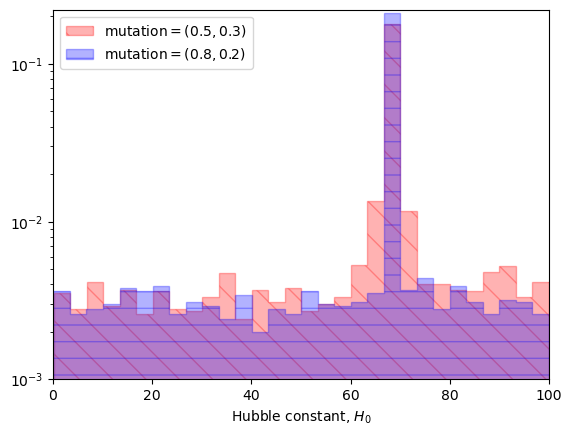

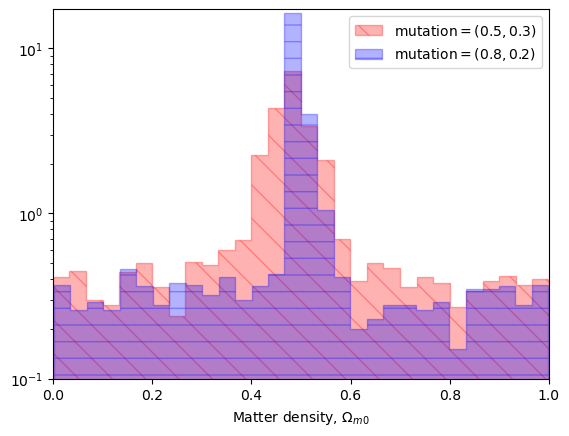

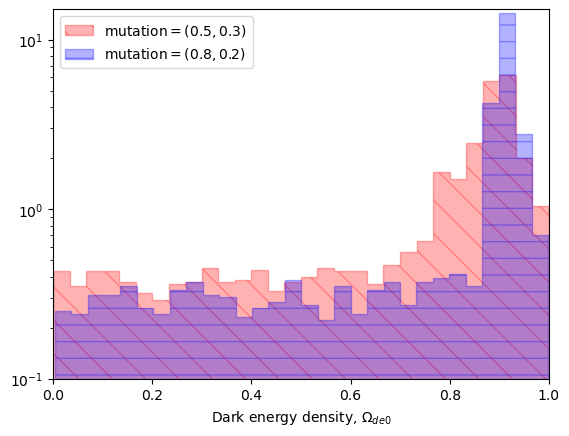

In [13]:
# load pygad results
ga_instance_0 = pygad.load('data/ga_cc_mutation_0')
ga_instance_1 = pygad.load('data/ga_cc_mutation_1')

ga_samps_0 = ga_instance_0.population
ga_samps_1 = ga_instance_1.population


# print statistics
use_latex=False
print('m_0'); print_stats(ga_samps_0, in_latex=use_latex); print()

print('m_1'); print_stats(ga_samps_1, in_latex=use_latex, precision=2); print()


# visualization
fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'mutation$=(0.5, 0.3)$', rasterized=True);
ax.hist(ga_samps_1[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'mutation$=(0.8, 0.2)$', rasterized=True);
ax.set_xlabel(r'Hubble constant, $H_0$')
ax.set_xlim(0,100)
ax.set_ylim(bottom=1e-3)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/cc_mutation_H0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'mutation$=(0.5, 0.3)$', rasterized=True);
ax.hist(ga_samps_1[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'mutation$=(0.8, 0.2)$', rasterized=True);
ax.set_xlabel(r'Matter density, $\Omega_{m0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=1e-1)
ax.set_yscale('log')
ax.legend(loc='upper right')
# fig.savefig('figs/cc_mutation_Om0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'mutation$=(0.5, 0.3)$', rasterized=True);
ax.hist(ga_samps_1[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'mutation$=(0.8, 0.2)$', rasterized=True);
ax.set_xlabel(r'Dark energy density, $\Omega_{de0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=1e-1)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/cc_mutation_Ode0.pdf')
plt.show()

#### 1.3 Changing crossover

Now for changing crossover rates; the results are;

c_0
H0 = 67.9 + 1.5 - 22.4
Om0 = 0.5 + 0.1 - 0.1
Ode0 = 0.8 + 0.1 - 0.4

c_1
H0 = 67.6 + 2.0 - 24.3
Om0 = 0.5 + 0.1 - 0.1
Ode0 = 0.8 + 0.1 - 0.4

c_2
H0 = 67.8 + 2.0 - 23.6
Om0 = 0.5 + 0.1 - 0.1
Ode0 = 0.9 + 0.1 - 0.4



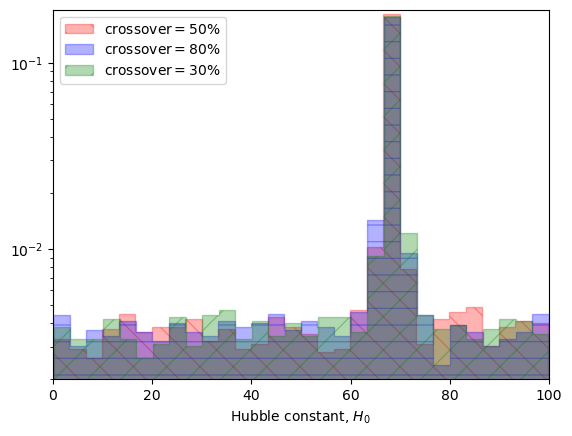

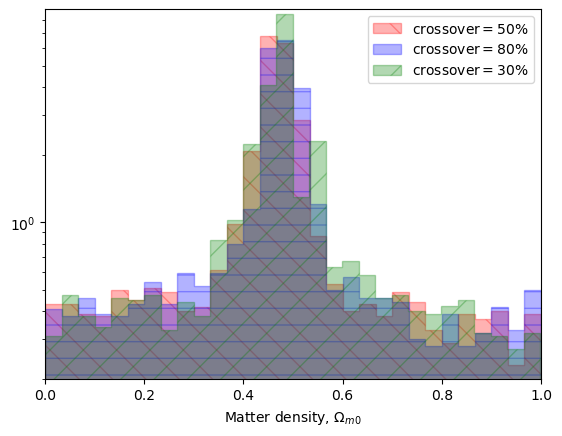

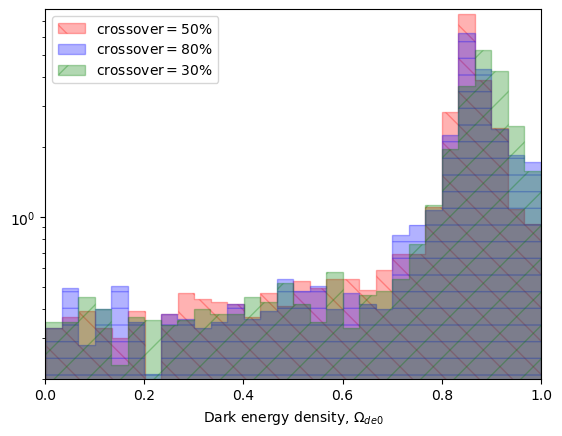

In [16]:
# load results
ga_instance_0 = pygad.load('data/ga_cc_crossover_0')
ga_instance_1 = pygad.load('data/ga_cc_crossover_1')
ga_instance_2 = pygad.load('data/ga_cc_crossover_2')

ga_samps_0 = ga_instance_0.population
ga_samps_1 = ga_instance_1.population
ga_samps_2 = ga_instance_2.population


# print sample statistics
use_latex=False
print('c_0'); print_stats(ga_samps_0, in_latex=use_latex); print()

print('c_1'); print_stats(ga_samps_1, in_latex=use_latex); print()

print('c_2'); print_stats(ga_samps_2, in_latex=use_latex); print()


# visualization of the distributions
fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'crossover$=50\%$', rasterized=True);
ax.hist(ga_samps_1[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'crossover$=80\%$', rasterized=True);
ax.hist(ga_samps_2[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'crossover$=30\%$', rasterized=True);
ax.set_xlabel(r'Hubble constant, $H_0$')
ax.set_xlim(0,100)
ax.set_ylim(bottom=2e-3)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/cc_crossover_H0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'crossover$=50\%$', rasterized=True);
ax.hist(ga_samps_1[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'crossover$=80\%$', rasterized=True);
ax.hist(ga_samps_2[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'crossover$=30\%$', rasterized=True);
ax.set_xlabel(r'Matter density, $\Omega_{m0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=2e-1)
ax.set_yscale('log')
ax.legend(loc='upper right')
# fig.savefig('figs/cc_crossover_Om0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'crossover$=50\%$', rasterized=True);
ax.hist(ga_samps_1[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'crossover$=80\%$', rasterized=True);
ax.hist(ga_samps_2[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'crossover$=30\%$', rasterized=True);
ax.set_xlabel(r'Dark energy density, $\Omega_{de0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=2e-1)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/cc_crossover_Ode0.pdf')
plt.show()

### 2. CC + SNe

In this secion we shall perform the same operations as CC only, except the samples have now been obtained with CC + SNe. Furthermore given the precision of this data set, we shall show Fisher matrix contours as a reference for a Gaussian distribution in the parameter distributions.

#### 2.1 Changing fitness

We proceed as usual, loading the samples and computing statistics;

In [18]:
# load pygad results
ga_instance_0 = pygad.load('data/ga_ccsne_fitness_0')
ga_instance_1 = pygad.load('data/ga_ccsne_fitness_1')
ga_instance_2 = pygad.load('data/ga_ccsne_fitness_2')

# compute last population
ga_samps_0 = ga_instance_0.population
ga_samps_1 = ga_instance_1.population
ga_samps_2 = ga_instance_2.population


# show sample stats
use_latex=False
print('FF_0'); print_stats(ga_samps_0, in_latex=use_latex); print()

print('FF_1'); print_stats(ga_samps_1, in_latex=use_latex); print()

print('FF_2'); print_stats(ga_samps_2, in_latex=use_latex, precision=1); print()

FF_0
H0 = 0.0 + 65.5 - 0.0
Om0 = 0.5 + 0.4 - 0.3
Ode0 = 0.5 + 0.3 - 0.4

FF_1
H0 = 71.9 + 1.3 - 23.7
Om0 = 0.4 + 0.3 - 0.3
Ode0 = 0.5 + 0.3 - 0.3

FF_2
H0 = 73.4 + 0.0 - 21.4
Om0 = 0.3 + 0.1 - 0.0
Ode0 = 0.7 + 0.0 - 0.2



For reference we compute the GA-Fisher distribution where the Fisher matrix is evaluated using the likelihood and the GA bestfit;

In [19]:
# gafisher_samps_0 = get_ga_fisher(ga_instance_0, llprob_CCSNe, nsamps=30000)
# gafisher_samps_1 = get_ga_fisher(ga_instance_1, llprob_CCSNe, nsamps=30000)
gafisher_samps_2 = get_ga_fisher(ga_instance_2, llprob_CCSNe, nsamps=30000)

/Users/rechbe/miniconda3/envs/cosmoga/lib/python3.11/site-packages/astropy/cosmology/_src/flrw/base.py:1179: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]


Results shown below are the right panels of Figure 3;

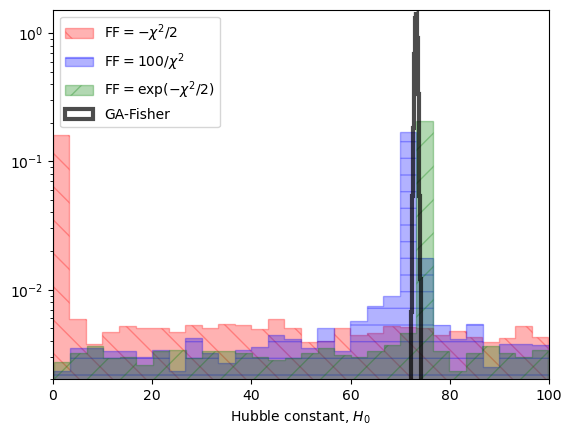

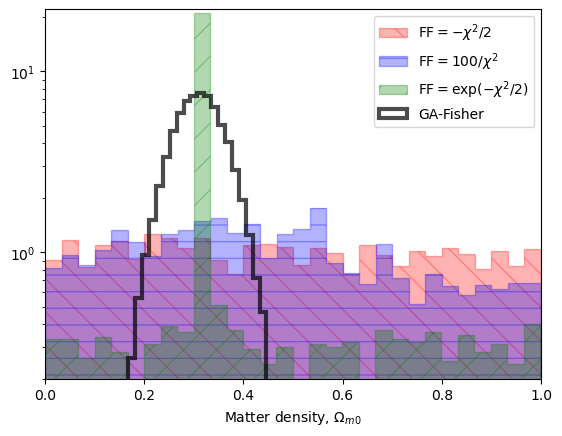

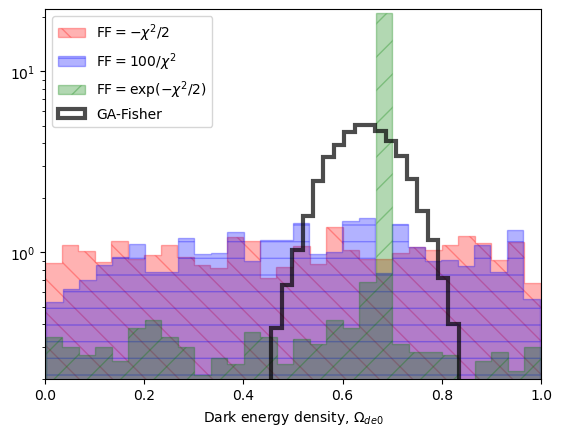

In [20]:
fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'FF$=-\chi^2/2$', rasterized=True);
ax.hist(ga_samps_1[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'FF$=100/\chi^2$', rasterized=True);
ax.hist(ga_samps_2[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'FF$=\exp(-\chi^2/2)$', rasterized=True);
ax.hist(gafisher_samps_2[:, 0], histtype = 'step', bins=30, \
        color = 'black', edgecolor = 'black', alpha = 0.7, density=True, \
        label = r'GA-Fisher', rasterized=True, lw=3);
ax.set_xlabel(r'Hubble constant, $H_0$')
ax.set_xlim(0,100)
ax.set_ylim(bottom=2e-3)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/ccsne_fitness_H0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'FF$=-\chi^2/2$', rasterized=True);
ax.hist(ga_samps_1[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'FF$=100/\chi^2$', rasterized=True);
ax.hist(ga_samps_2[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'FF$=\exp(-\chi^2/2)$', rasterized=True);
ax.hist(gafisher_samps_2[:, 1], histtype = 'step', bins=30, \
        color = 'black', edgecolor = 'black', alpha = 0.7, density=True, \
        label = r'GA-Fisher', rasterized=True, lw=3);
ax.set_xlabel(r'Matter density, $\Omega_{m0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=2e-1)
ax.set_yscale('log')
ax.legend(loc='upper right')
# fig.savefig('figs/ccsne_fitness_Om0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'FF$=-\chi^2/2$', rasterized=True);
ax.hist(ga_samps_1[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'FF$=100/\chi^2$', rasterized=True);
ax.hist(ga_samps_2[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'FF$=\exp(-\chi^2/2)$', rasterized=True);
ax.hist(gafisher_samps_2[:, 2], histtype = 'step', bins=30, \
        color = 'black', edgecolor = 'black', alpha = 0.7, density=True, \
        label = r'GA-Fisher', rasterized=True, lw=3);
ax.set_xlabel(r'Dark energy density, $\Omega_{de0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=2e-1)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/ccsne_fitness_Ode0.pdf')
plt.show()

#### 2.2 Changing mutation

The corresponding results all at once for changing mutation rates are shown below;

m_0
H0 = 73.4 + 0.0 - 21.0
Om0 = 0.3 + 0.2 - 0.0
Ode0 = 0.7 + 0.0 - 0.2

m_1
H0 = 73.3 + 0.0 - 3.1
Om0 = 0.3 + 0.0 - 0.0
Ode0 = 0.7 + 0.0 - 0.0



/Users/rechbe/miniconda3/envs/cosmoga/lib/python3.11/site-packages/astropy/cosmology/_src/flrw/base.py:1179: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]


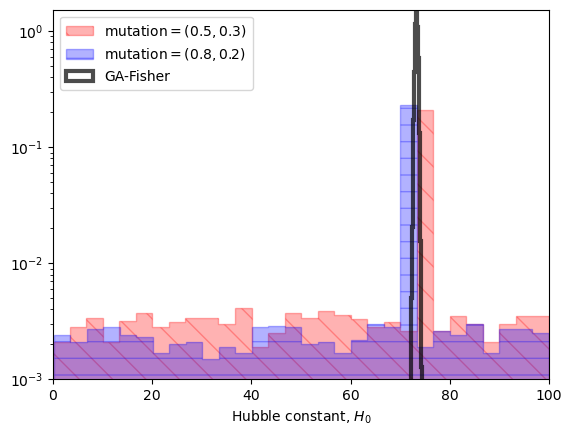

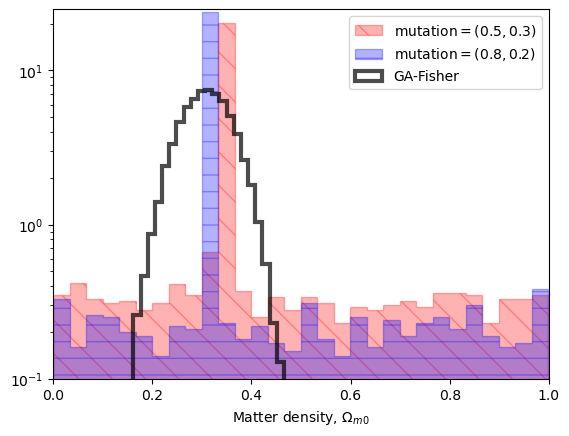

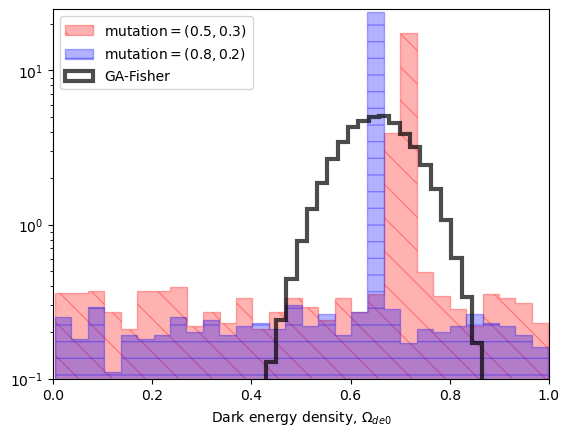

In [21]:
# load pygad instances
ga_instance_0 = pygad.load('data/ga_ccsne_mutation_0')
ga_instance_1 = pygad.load('data/ga_ccsne_mutation_1')

# recover final populations
ga_samps_0 = ga_instance_0.population
ga_samps_1 = ga_instance_1.population


# print statistics
use_latex=False
print('m_0'); print_stats(ga_samps_0, in_latex=use_latex, precision=1); print()

print('m_1'); print_stats(ga_samps_1, in_latex=use_latex, precision=1); print()


# compute reference GA-Fisher sample
# gafisher_samps_0 = get_ga_fisher(ga_instance_0, llprob_CCSNe, nsamps=30000)
gafisher_samps_1 = get_ga_fisher(ga_instance_1, llprob_CCSNe, nsamps=30000);
# gafisher_samps_2 = get_ga_fisher(ga_instance_2, llprob_CCSNe, nsamps=30000)


# visualization of the distributions
fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'mutation$=(0.5, 0.3)$', rasterized=True);
ax.hist(ga_samps_1[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'mutation$=(0.8, 0.2)$', rasterized=True);
ax.hist(gafisher_samps_1[:, 0], histtype = 'step', bins=30, \
        color = 'black', edgecolor = 'black', alpha = 0.7, density=True, \
        label = r'GA-Fisher', rasterized=True, lw=3);
ax.set_xlabel(r'Hubble constant, $H_0$')
ax.set_xlim(0,100)
ax.set_ylim(bottom=1e-3)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/ccsne_mutation_H0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'mutation$=(0.5, 0.3)$', rasterized=True);
ax.hist(ga_samps_1[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'mutation$=(0.8, 0.2)$', rasterized=True);
ax.hist(gafisher_samps_1[:, 1], histtype = 'step', bins=30, \
        color = 'black', edgecolor = 'black', alpha = 0.7, density=True, \
        label = r'GA-Fisher', rasterized=True, lw=3);
ax.set_xlabel(r'Matter density, $\Omega_{m0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=1e-1)
ax.set_yscale('log')
ax.legend(loc='upper right')
# fig.savefig('figs/ccsne_mutation_Om0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'mutation$=(0.5, 0.3)$', rasterized=True);
ax.hist(ga_samps_1[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'mutation$=(0.8, 0.2)$', rasterized=True);
ax.hist(gafisher_samps_1[:, 2], histtype = 'step', bins=30, \
        color = 'black', edgecolor = 'black', alpha = 0.7, density=True, \
        label = r'GA-Fisher', rasterized=True, lw=3);
ax.set_xlabel(r'Dark energy density, $\Omega_{de0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=1e-1)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/ccsne_mutation_Ode0.pdf')
plt.show()

#### 2.3 Changing crossover

Lastly we show the results for changing crossover with CC + SNe data set;

c_0
H0 = 73.227 + 0.000 - 23.085
Om0 = 0.312 + 0.121 - 0.000
Ode0 = 0.648 + 0.003 - 0.134

c_1
H0 = 73.293 + 0.000 - 22.579
Om0 = 0.312 + 0.185 - 0.000
Ode0 = 0.658 + 0.002 - 0.145

c_2
H0 = 73.2 + 0.0 - 19.9
Om0 = 0.3 + 0.2 - 0.0
Ode0 = 0.7 + 0.0 - 0.2



/Users/rechbe/miniconda3/envs/cosmoga/lib/python3.11/site-packages/astropy/cosmology/_src/flrw/base.py:1179: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]


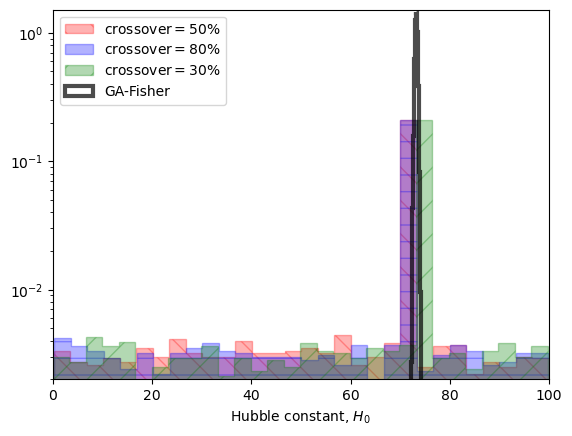

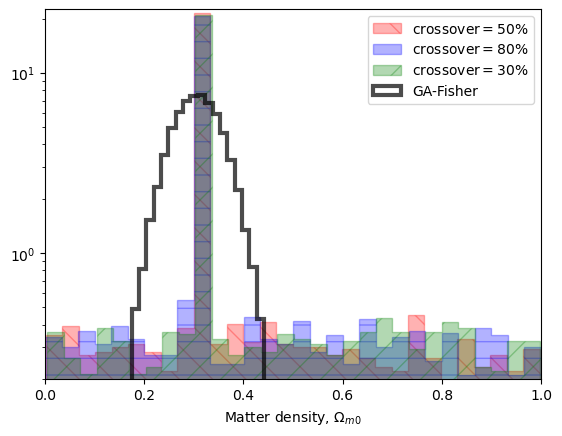

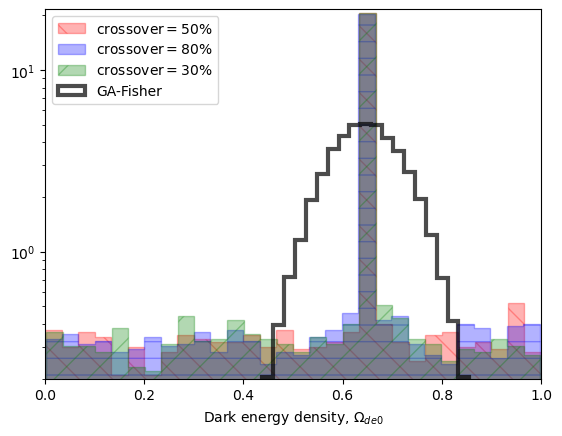

In [22]:
# load pygad instances
ga_instance_0 = pygad.load('data/ga_ccsne_crossover_0')
ga_instance_1 = pygad.load('data/ga_ccsne_crossover_1')
ga_instance_2 = pygad.load('data/ga_ccsne_crossover_2')

# load last populations
ga_samps_0 = ga_instance_0.population
ga_samps_1 = ga_instance_1.population
ga_samps_2 = ga_instance_2.population


# compute and print sample statistics
use_latex=False
print('c_0'); print_stats(ga_samps_0, in_latex=use_latex, precision=3); print()

print('c_1'); print_stats(ga_samps_1, in_latex=use_latex, precision=3); print()

print('c_2'); print_stats(ga_samps_2, in_latex=use_latex, precision=1); print()


# compute reference GA-Fisher sample
# gafisher_samps_0 = get_ga_fisher(ga_instance_0, llprob_CCSNe, nsamps=30000)
# gafisher_samps_1 = get_ga_fisher(ga_instance_1, llprob_CCSNe, nsamps=30000)
gafisher_samps_2 = get_ga_fisher(ga_instance_2, llprob_CCSNe, nsamps=30000);


# visualization of the distributions
fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'crossover$=50\%$', rasterized=True);
ax.hist(ga_samps_1[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'crossover$=80\%$', rasterized=True);
ax.hist(ga_samps_2[:, 0], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'crossover$=30\%$', rasterized=True);
ax.hist(gafisher_samps_2[:, 0], histtype = 'step', bins=30, \
        color = 'black', edgecolor = 'black', alpha = 0.7, density=True, \
        label = r'GA-Fisher', rasterized=True, lw=3);
ax.set_xlabel(r'Hubble constant, $H_0$')
ax.set_xlim(0,100)
ax.set_ylim(bottom=2e-3)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/ccsne_crossover_H0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'crossover$=50\%$', rasterized=True);
ax.hist(ga_samps_1[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'crossover$=80\%$', rasterized=True);
ax.hist(ga_samps_2[:, 1], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'crossover$=30\%$', rasterized=True);
ax.hist(gafisher_samps_2[:, 1], histtype = 'step', bins=30, \
        color = 'black', edgecolor = 'black', alpha = 0.7, density=True, \
        label = r'GA-Fisher', rasterized=True, lw=3);
ax.set_xlabel(r'Matter density, $\Omega_{m0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=2e-1)
ax.set_yscale('log')
ax.legend(loc='upper right')
# fig.savefig('figs/ccsne_crossover_Om0.pdf')
plt.show()

fig, ax = plt.subplots()
ax.hist(ga_samps_0[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'red', edgecolor = 'red', hatch = '\\', alpha = 0.3, density=True, \
        label = r'crossover$=50\%$', rasterized=True);
ax.hist(ga_samps_1[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'blue', edgecolor = 'blue', hatch = '-', alpha = 0.3, density=True, \
        label = r'crossover$=80\%$', rasterized=True);
ax.hist(ga_samps_2[:, 2], histtype = 'stepfilled', bins=30, \
        color = 'green', edgecolor = 'green', hatch = '/', alpha = 0.3, density=True, \
        label = r'crossover$=30\%$', rasterized=True);
ax.hist(gafisher_samps_2[:, 2], histtype = 'step', bins=30, \
        color = 'black', edgecolor = 'black', alpha = 0.7, density=True, \
        label = r'GA-Fisher', rasterized=True, lw=3);
ax.set_xlabel(r'Dark energy density, $\Omega_{de0}$')
ax.set_xlim(0,1)
ax.set_ylim(bottom=2e-1)
ax.set_yscale('log')
ax.legend(loc='upper left')
# fig.savefig('figs/ccsne_crossover_Ode0.pdf')
plt.show()